In [21]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from numpy import asarray
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score, classification_report

In [2]:
columns = ['CLOC', 'LC', 'MLOC', 'LM', 'LMC', 'LMCS', 'LPLPAR', 'LPL', 'NOC', 'LLFPAR', 'NOO', 'LLF']
df = pd.read_csv('code_smell_dataset.csv', usecols=columns)
df

,CLOC,LC,MLOC,LM,LMC,LMCS,LPLPAR,LPL,NOC,LLFPAR,NOO,LLF
0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44.0,1.0,34.0,0.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0
3,44.0,1.0,34.0,0.0,2.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0
4,44.0,1.0,34.0,0.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
375525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,1.0,7.0,0.0
375526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,0.0
375527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,2.0,5.0,0.0
375528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,4.0,0.0


In [3]:
# Assuming df is your DataFrame
float_columns = df.select_dtypes(include='float').columns
# Convert all float columns to int
df[float_columns] = df[float_columns].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375530 entries, 0 to 375529
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   CLOC    375530 non-null  int64
 1   LC      375530 non-null  int64
 2   MLOC    375530 non-null  int64
 3   LM      375530 non-null  int64
 4   LMC     375530 non-null  int64
 5   LMCS    375530 non-null  int64
 6   LPLPAR  375530 non-null  int64
 7   LPL     375530 non-null  int64
 8   NOC     375530 non-null  int64
 9   LLFPAR  375530 non-null  int64
 10  NOO     375530 non-null  int64
 11  LLF     375530 non-null  int64
dtypes: int64(12)
memory usage: 34.4 MB


In [9]:
# Define your target columns
target_columns = ['LC', 'LM', 'LMCS', 'LPL', 'LLF']

# Find the minimum count among the labels
min_count = min(df[target_columns].sum(axis=0))
print(min_count)

# Initialize a list to store DataFrames for each label
balanced_dfs = []

# Loop through each target column
for target_column in target_columns:
    # Identify indices of instances with ones in the current target column
    ones_indices = df[df[target_column] == 1].index
    
    # Randomly select a subset of instances equal to the minimum count
    selected_indices = np.random.choice(ones_indices, min_count, replace=False)
    
    # Create a new DataFrame with the selected instances
    selected_df = df.loc[selected_indices]
    
    # Append the selected DataFrame to the list
    balanced_dfs.append(selected_df)

# Concatenate the DataFrames in the list to create the final balanced DataFrame
balanced_df = pd.concat(balanced_dfs, ignore_index=True)
balanced_df

29925


,CLOC,LC,MLOC,LM,LMC,LMCS,LPLPAR,LPL,NOC,LLFPAR,NOO,LLF
0,77,1,15,0,2,0,1,0,30,1,6,0
1,89,1,81,1,2,0,1,0,0,0,0,0
2,41,1,1,0,2,0,1,0,27,1,4,0
3,43,1,15,0,2,0,1,0,30,1,6,0
4,43,1,182,1,2,0,1,0,30,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149620,50,1,3,0,2,0,8,1,83,1,23,1
149621,93,1,8,0,2,0,7,1,88,1,25,1
149622,150,1,16,0,2,0,7,1,83,1,23,1
149623,982,1,70,1,3,0,1,0,138,1,21,1


In [5]:
# # Calculate the counts of zero and one
# value_counts = df['LLF'].value_counts()

# # Extract the counts for zero and one
# count_zero = value_counts.get(0, 0)
# count_one = value_counts.get(1, 0)

# # Calculate the difference
# difference = count_zero - count_one

# # Identify the indices of rows where the specified column has label 0
# zero_indices = df[df['LLF'] == 0].index

# # Randomly select a subset of indices to remove
# indices_to_remove = np.random.choice(zero_indices, difference, replace=False)

# # Create a new DataFrame without the selected rows
# df = df.drop(indices_to_remove)
# filtered_df

In [10]:
print(balanced_df['LLF'].value_counts())
print(balanced_df['LPL'].value_counts())
print(balanced_df['LM'].value_counts())
print(balanced_df['LC'].value_counts())
print(balanced_df['LMCS'].value_counts())

LLF
0    107840
1     41785
Name: count, dtype: int64
LPL
0    88007
1    61618
Name: count, dtype: int64
LM
1    75320
0    74305
Name: count, dtype: int64
LC
1    89086
0    60539
Name: count, dtype: int64
LMCS
0    107566
1     42059
Name: count, dtype: int64


In [11]:
# seperating data and labels 
X = df.drop(columns=['LC', 'LM', 'LMCS', 'LPL', 'LLF'], axis=1)
Y = df.drop(columns=['CLOC', 'MLOC', 'LMC', 'LPLPAR', 'NOC', 'LLFPAR', 'NOO'], axis=1)
print(X.head())
print(Y.head())

   CLOC  MLOC  LMC  LPLPAR  NOC  LLFPAR  NOO
0    38     0    0       0    0       0    0
1    42     0    0       0    0       0    0
2    44    34    2      13    0       0    0
3    44    34    2       6    0       0    0
4    44    34    2      13    0       0    0
   LC  LM  LMCS  LPL  LLF
0   1   0     0    0    0
1   1   0     0    0    0
2   1   0     0    1    0
3   1   0     0    1    0
4   1   0     0    1    0


In [12]:
# Handling Outliers
def handle_outliers(df, IQR, variable):
    lower_bridge = df[variable].quantile(0.25) - (IQR*1.5)
    upper_bridge = df[variable].quantile(0.75) + (IQR*1.5)
    
    df.loc[df[variable] >= upper_bridge, variable] = upper_bridge
    df.loc[df[variable] <= lower_bridge, variable] = lower_bridge

IQR_CLOC = df['CLOC'].quantile(0.75) - df['CLOC'].quantile(0.25)
IQR_MLOC = df['MLOC'].quantile(0.75) - df['MLOC'].quantile(0.25)
IQR_LMC = df['LMC'].quantile(0.75) - df['LMC'].quantile(0.25)
IQR_LPLPAR = df['LPLPAR'].quantile(0.75) - df['LPLPAR'].quantile(0.25)
IQR_NOC = df['NOC'].quantile(0.75) - df['NOC'].quantile(0.25)
IQR_LLFPAR = df['LLFPAR'].quantile(0.75) - df['LLFPAR'].quantile(0.25)
IQR_NOO = df['NOO'].quantile(0.75) - df['NOO'].quantile(0.25)

handle_outliers(X, IQR_CLOC, 'CLOC')
handle_outliers(X, IQR_MLOC, 'MLOC')
handle_outliers(X, IQR_LMC, 'LMC')
handle_outliers(X, IQR_LPLPAR, 'LPLPAR')
handle_outliers(X, IQR_NOC, 'NOC')
handle_outliers(X, IQR_LLFPAR, 'LLFPAR')
handle_outliers(X, IQR_NOO, 'NOO')

/var/folders/n1/j4qhhn297tj4tnrpbsvg4q800000gn/T/ipykernel_3506/2324855106.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '142.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[variable] >= upper_bridge, variable] = upper_bridge
/var/folders/n1/j4qhhn297tj4tnrpbsvg4q800000gn/T/ipykernel_3506/2324855106.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[variable] >= upper_bridge, variable] = upper_bridge


In [13]:
# train test split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/var/folders/n1/j4qhhn297tj4tnrpbsvg4q800000gn/T/ipykernel_3506/2404590566.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


Text(0.5, 1.0, 'X_train After Scaling')

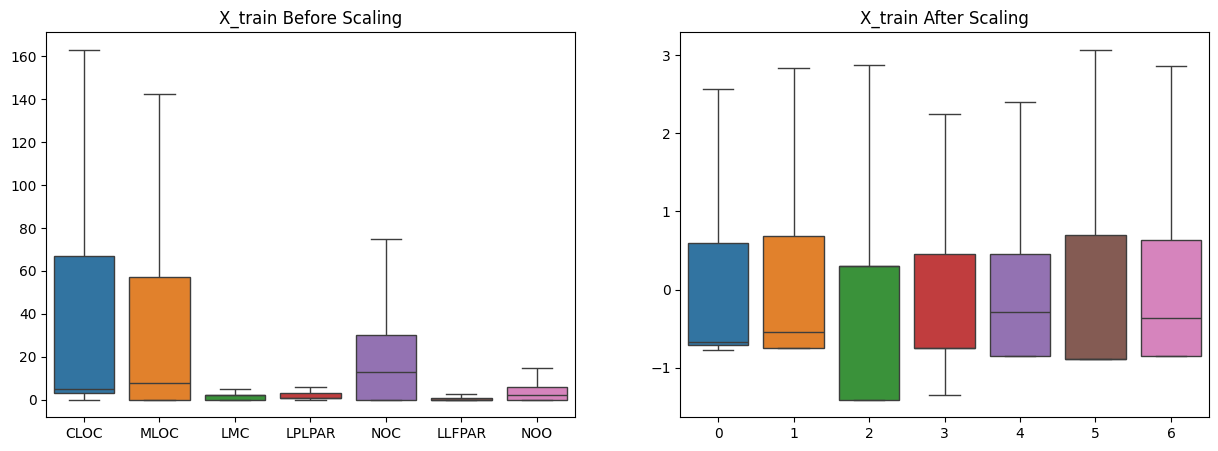

In [15]:
# Visualize the effect of scaling
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title('X_train Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.savefig("scaling.png")
plt.title('X_train After Scaling')

In [19]:
# Create, train, fit and evaluate model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, Y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, Y_test))

loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/50
18777/18777 [==============================] - 6s 322us/step - loss: 0.0410 - accuracy: 0.6164 - val_loss: 0.0029 - val_accuracy: 0.5367
Epoch 2/50
18777/18777 [==============================] - 6s 322us/step - loss: 0.0021 - accuracy: 0.5356 - val_loss: 0.0014 - val_accuracy: 0.5361
Epoch 3/50
18777/18777 [==============================] - 6s 325us/step - loss: 0.0012 - accuracy: 0.5361 - val_loss: 9.5759e-04 - val_accuracy: 0.5353
Epoch 4/50
18777/18777 [==============================] - 6s 321us/step - loss: 8.5933e-04 - accuracy: 0.5382 - val_loss: 6.0676e-04 - val_accuracy: 0.5427
Epoch 5/50
18777/18777 [==============================] - 6s 322us/step - loss: 5.8057e-04 - accuracy: 0.5544 - val_loss: 4.5031e-04 - val_accuracy: 0.5950
Epoch 6/50
18777/18777 [==============================] - 6s 322us/step - loss: 4.4214e-04 - accuracy: 0.6211 - val_loss: 3.8556e-04 - val_accuracy: 0.6339
Epoch 7/50
18777/18777 [==============================] - 6s 321us/step - loss: 3.51

In [35]:
# Make predictions on new data
new_data = np.array([[20, 20, 8, 1, 53, 2, 8]])
new_data_scaled = scaler.transform(new_data)
predictions = model.predict(new_data_scaled)

print(f'Predicted Labels: {predictions}')

1/1 [==============================] - 0s 12ms/step
Predicted Labels: [[9.2135233e-05 1.3045552e-02 1.0000000e+00 7.9313344e-12 2.9121131e-05]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
